<div style="border-radius: 15px; box-shadow: 2px 2px 4px; border: 1px solid; background:OldLace; padding: 20px">

# Выбор локации скважины


## Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину. Шаги для выбора локации обычно такие:
В избранном регионе собирают характеристики для скважин: 
- качество нефти и объём её запасов;
- Строят модель для предсказания объёма запасов в новых скважинах;
- Выбирают скважины с самыми высокими оценками значений;
- Определяют регион с максимальной суммарной прибылью отобранных скважин.

Вам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Постройте модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой Bootstrap.

## Данные

- id — уникальный идентификатор скважины
- f0, f1, f2 — три признака точек 
- product — объём запасов в скважине (тыс. баррелей)

## Содержание работы

1. Предобработка данных
2. Исследовательский анализ данных
3. Обучение модели
4. Расчет прибыли регионов

<div style="border-radius: 15px; box-shadow: 2px 2px 4px; border: 1px solid; background:OldLace; padding: 20px">


## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor

from optuna.integration import OptunaSearchCV
from optuna.distributions import FloatDistribution
from scipy import stats as st

import phik
import warnings

import os
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12,12)

C:\Users\Alexander\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
try:
    geo_data_0 = pd.read_csv('geo_data_0.csv')
    geo_data_1 = pd.read_csv('geo_data_1.csv')
    geo_data_2 = pd.read_csv('geo_data_2.csv')

except:
    geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
    geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
    geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

<div style="border-radius: 15px; box-shadow: 2px 2px 4px; border: 1px solid; background:OldLace; padding: 20px">

## Предобработка данных

In [3]:
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [4]:
geo_data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
geo_data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [7]:
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
geo_data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [9]:
for data in [geo_data_0, geo_data_1, geo_data_2]:
    for cl in data.columns:
        print(f'количество уникальных значений: {data[cl].nunique()}')
    print('\n')    

количество уникальных значений: 99990
количество уникальных значений: 100000
количество уникальных значений: 100000
количество уникальных значений: 100000
количество уникальных значений: 100000


количество уникальных значений: 99996
количество уникальных значений: 100000
количество уникальных значений: 100000
количество уникальных значений: 100000
количество уникальных значений: 12


количество уникальных значений: 99996
количество уникальных значений: 100000
количество уникальных значений: 100000
количество уникальных значений: 100000
количество уникальных значений: 100000




In [10]:
geo_data_1['f2'].unique()

array([-5.87601369e-03,  9.99182737e-01,  5.00116016e+00, ...,
        4.99865060e+00,  1.00014635e+00, -3.29851829e-03])

Во всех трех таблицах столбец `id` имеет повторяющиеся имена.Удалим одинаковые id.Также во второй таблице целевой признак имеет дискретные значения

In [11]:
geo_data_0 = geo_data_0.drop(geo_data_0.loc[geo_data_0['id'].isin(geo_data_0['id'].value_counts().head(10).index)].index)
geo_data_1 = geo_data_1.drop(geo_data_1.loc[geo_data_1['id'].isin(geo_data_1['id'].value_counts().head(4).index)].index)
geo_data_2 = geo_data_2.drop(geo_data_2.loc[geo_data_2['id'].isin(geo_data_2['id'].value_counts().head(4).index)].index)

In [12]:
geo_data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [13]:
for data in [geo_data_0, geo_data_1, geo_data_2]:
    print('Количество пропусков')
    print (data.isna().sum())
    print(f'Количество дубликатов {data.duplicated().sum()}')
    print('\n')

Количество пропусков
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
Количество дубликатов 0


Количество пропусков
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
Количество дубликатов 0


Количество пропусков
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
Количество дубликатов 0




<div style="border-radius: 15px; box-shadow: 2px 2px 4px; border: 1px solid; background:OldLace; padding: 20px">

## Вывод по предобработке данных

В ходе предобработки данных не были выявлены пропуски и дубликаты, однако были замечены повторения id,которые были впоследствии удалены. Также для второго региона можно заметить, что целевой признак имеет дискретный набор данных.

<div style="border-radius: 15px; box-shadow: 2px 2px 4px; border: 1px solid; background:OldLace; padding: 20px">

## Исследовательский анализ данных

In [14]:
def plt_num(data):
    '''
    data - датафрейм
    num - столбцы с численныеми значениями
    col - количество столбцов в таблице
    row - количество строк в таблице
    '''
    num = data.select_dtypes(exclude='object').columns
    col = len(num) // 2
    row = len(num) - col
    index = 1
    for cl in num:
        plt.subplot(row, col, index)
        sns.histplot(data[cl], kde=True, bins=40)
        plt.xlabel(f'{cl}')
        plt.ylabel('Количество')
        plt.title(f'{cl}')
        index += 1
    plt.tight_layout()
    plt.show()

In [15]:
def plt_box(data):
    '''
    data - датафрейм
    num - столбцы с численныеми значениями
    col - количество столбцов в таблице
    row - количество строк в таблице
    '''
    num = data.select_dtypes(exclude='object').columns
    col = len(num) // 2
    row = len(num) - col
    index = 1
    for cl in num:
        plt.subplot(row, col, index)
        sns.boxplot(data[cl])
        plt.xlabel(f'{cl}')
        plt.title(f'{cl}')
        index += 1
    plt.tight_layout()
    plt.show()

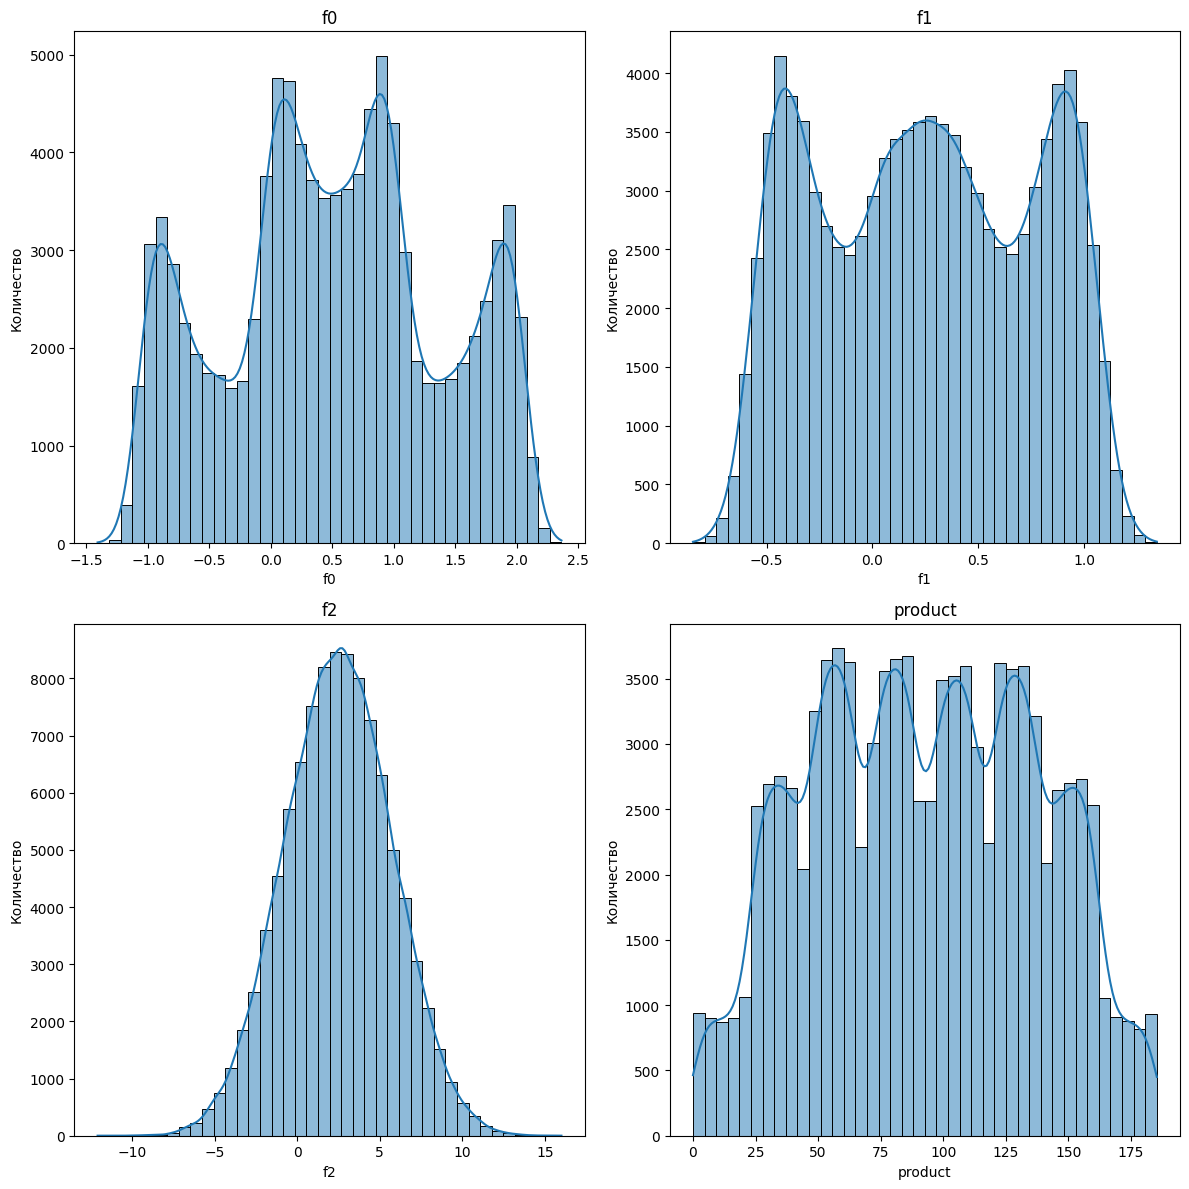

In [16]:
plt_num(geo_data_0)

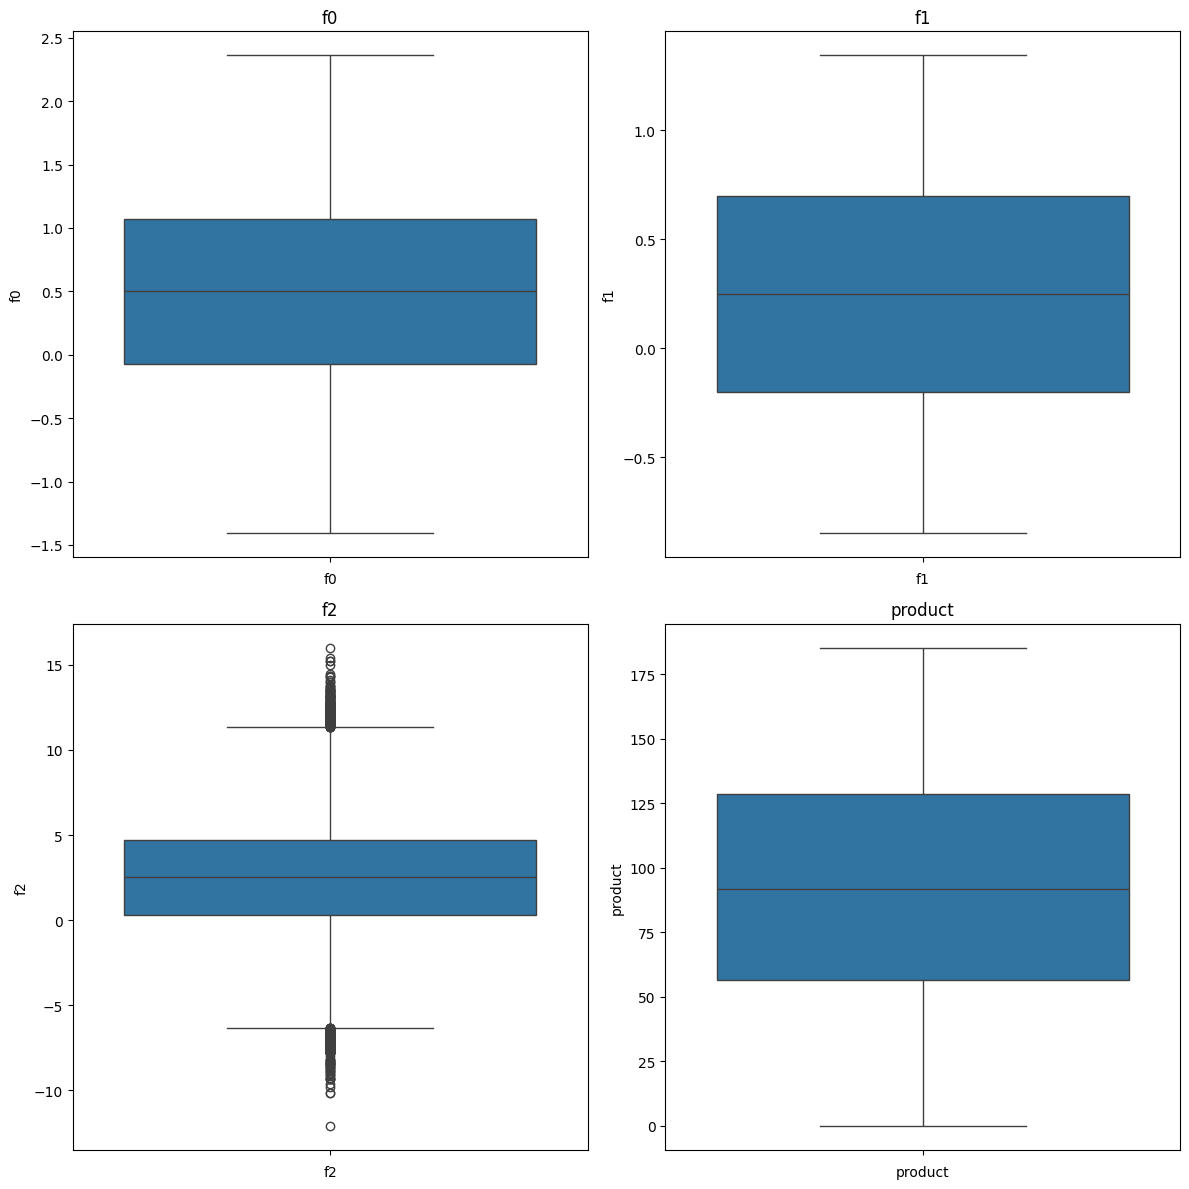

In [17]:
plt_box(geo_data_0)

По распределению количественных переменных можно заметить, что **f0, f1, product**  имеет множество пиков, а вот **f2** имеет вид нормального распределения с длинным левым хвостом. Также выделим тот факт, что для столбцов **f0, f1, product** не наблюдаются аномальные значения

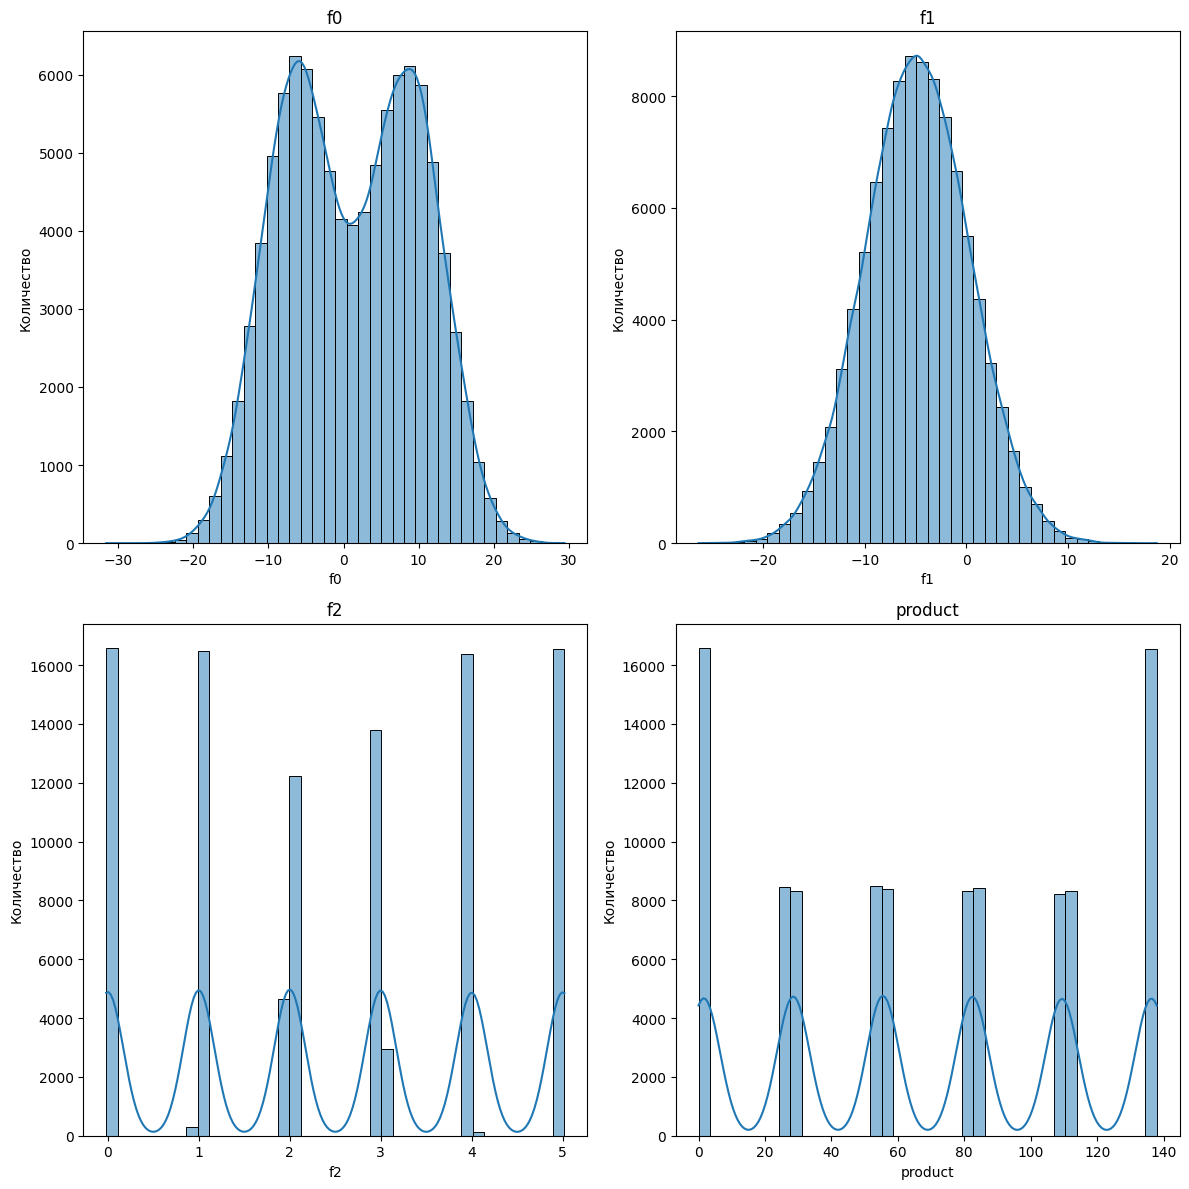

In [18]:
plt_num(geo_data_1)

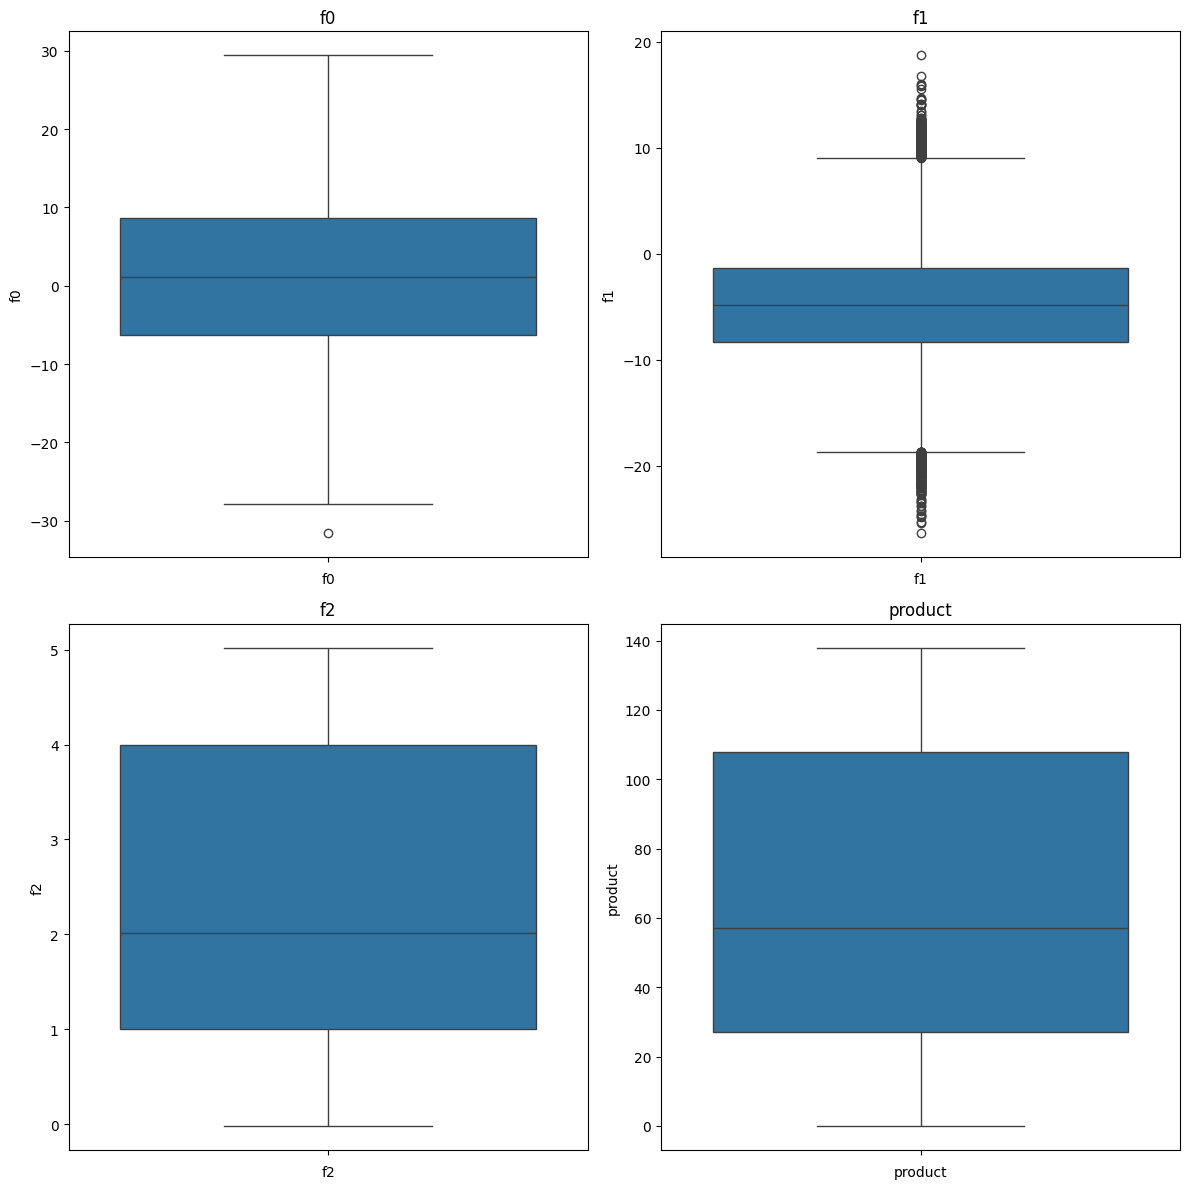

In [19]:
plt_box(geo_data_1)

Как уже было подмечено ранее, столбец **product** имеет ограниченное количество значений. Столбец **f0** имеет вид двумодального распределения, **f1** нормальное распределение.Распределение столбца **f2** как и у целевого признака имеет дискретный характер.

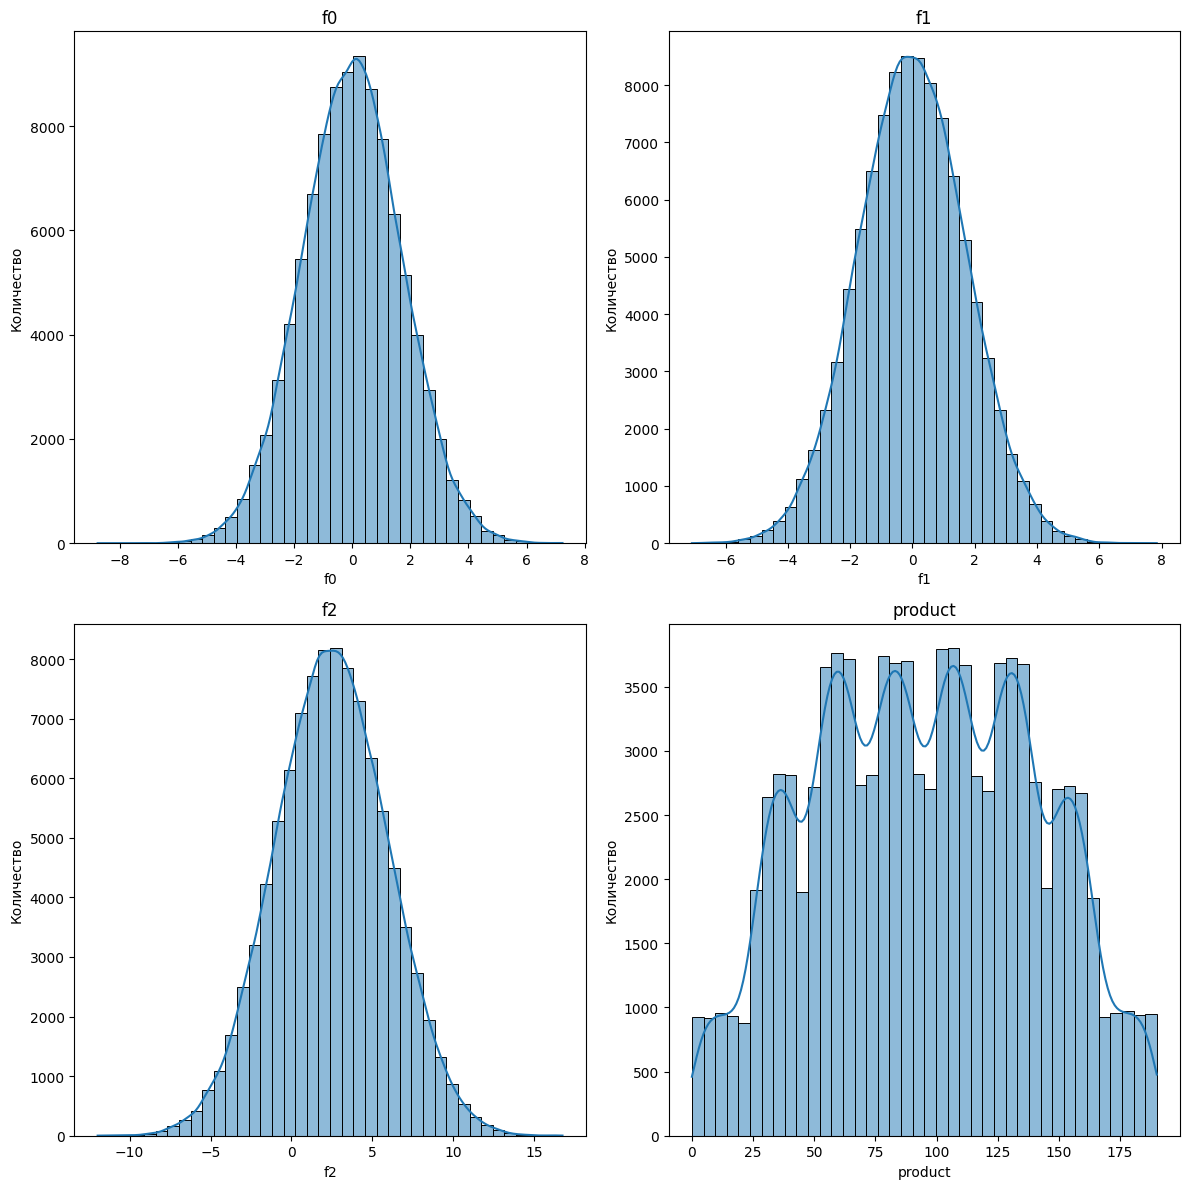

In [20]:
plt_num(geo_data_2)

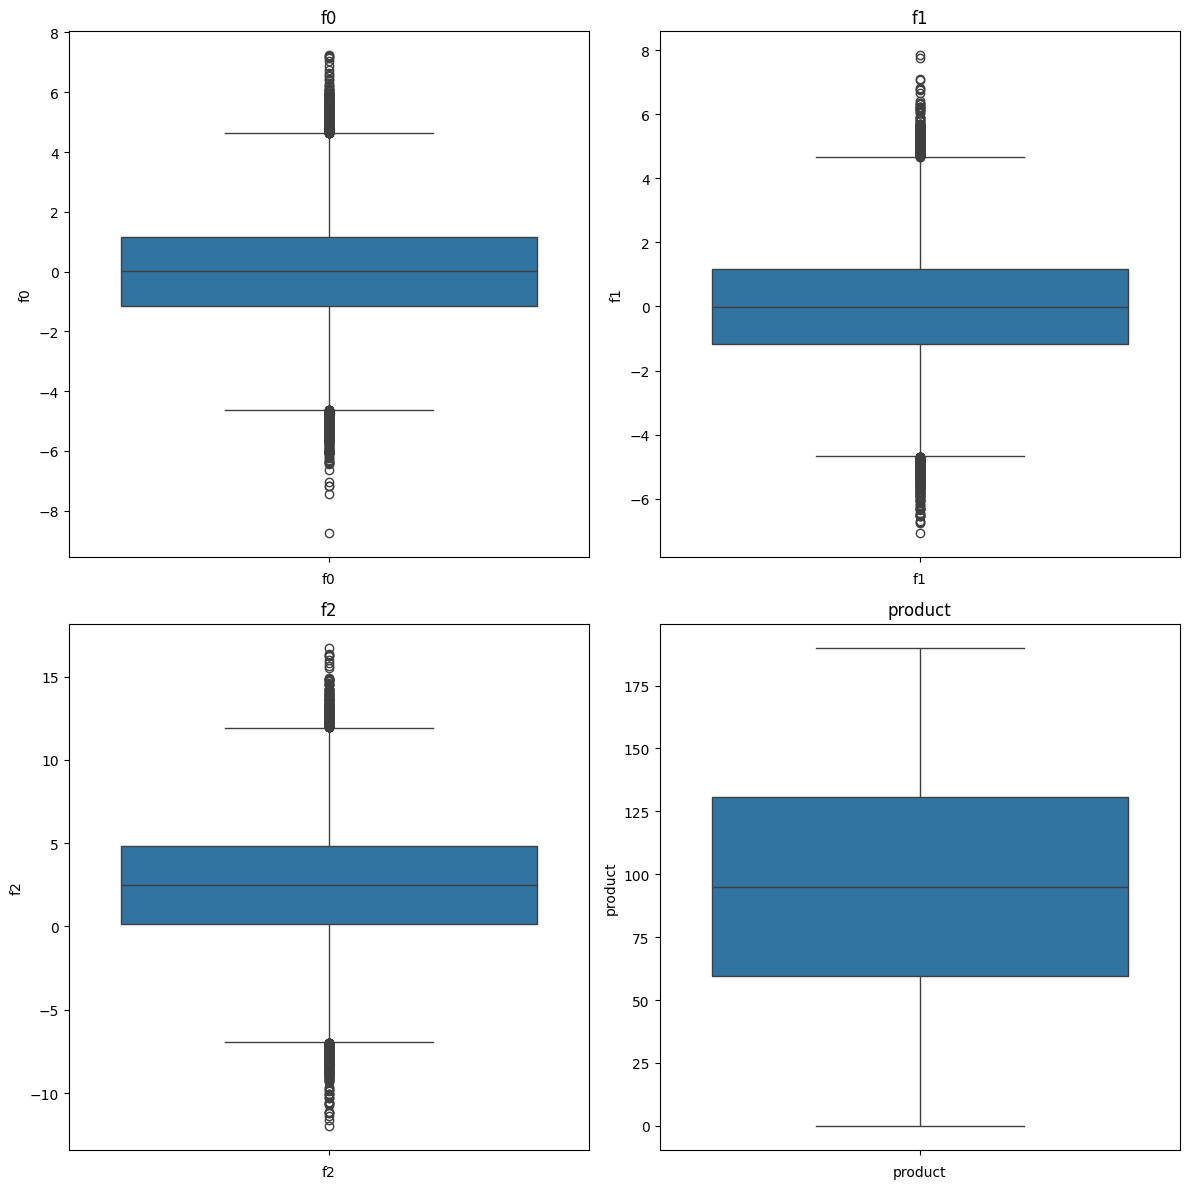

In [21]:
plt_box(geo_data_2)

Для таблицы **geo_data_2** предикторы имеют нормальное распределение с аномальными значениями, а целевая переменная имеет множество пиков. 

<div style="border-radius: 15px; box-shadow: 2px 2px 4px; border: 1px solid; background:OldLace; padding: 20px">

## Вывод по исследовательскому анализу

1) По распределению количественных переменных можно заметить, что **f0, f1, product**  имеет множество пиков, а вот **f2** имеет вид нормального распределения с длинным левым хвостом. Также выделим тот факт, что для столбцов **f0, f1, product** не наблюдаются аномальные значения

2) Столбец **f0** имеет вид двумодального распределения, **f1** нормальное распределение. Как уже было подмечено ранее, столбец **product** имеет ограниченное количество значений.

3) Столбец **f0** имеет вид двумодального распределения, **f1** нормальное распределение.Распределение столбца **f2** как и у целевого признака имеет дискретный характер.Для таблицы **geo_data_2** предикторы имеют нормальное распределение с аномальными значениями, а целевая переменная имеет множество пиков. 

<div style="border-radius: 15px; box-shadow: 2px 2px 4px; border: 1px solid; background:OldLace; padding: 20px">

## Корреляционный анализ

Напишем функцию, определяющая показатель VIF

In [22]:
def vif(X,num_col, cat_col):
    """
    На входе X - признаки,
             num_col - список количественных признаков
             cat_col - список категориальны признаков 
    На выходе получаем датафрейм с коэффициентами мультиколлениарности
    
    """
    
    ohe = OneHotEncoder(drop='first', sparse=False)
    scaler = StandardScaler()

    if len(num_col) == 0:
         X_ohe = ohe.fit_transform(X[cat_col])
         X = pd.DataFrame(X_ohe, columns=ohe.get_feature_names_out())
    if len(cat_col) == 0:
        X_num = scaler.fit_transform(X[num_col])
        X = pd.DataFrame(X_num, columns=num_col)
    else:
        X_ohe = ohe.fit_transform(X[cat_col])
        X_num = scaler.fit_transform(X[num_col])
        X_ohe = pd.DataFrame(X_ohe, columns=ohe.get_feature_names_out())
        X_num = pd.DataFrame(X_num, columns=num_col)
        X = pd.concat([X_num, X_ohe], axis=1)
# Вычисление VIF
    vif = pd.DataFrame()
    vif["Features"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))] 

    # Вывод VIF
    return vif

In [23]:
num_col = ['f0', 'f1', 'f2', 'product']
cat_col = []

In [24]:
geo_data_0[['f0','f1','f2', 'product']] = geo_data_0[['f0','f1','f2', 'product']].astype('float32')

In [25]:
vif(geo_data_0, num_col, cat_col)

,Features,VIF
0,f0,1.248701
1,f1,1.276596
2,f2,1.323627
3,product,1.380598


In [26]:
vif(geo_data_1, num_col, cat_col)

,Features,VIF
0,f0,3.163099
1,f1,1.049794
2,f2,2660.062569
3,product,2662.580159


In [27]:
vif(geo_data_2, num_col, cat_col)

,Features,VIF
0,f0,1.000004
1,f1,1.000003
2,f2,1.248134
3,product,1.248139


Можем наблюдать, что во втором регионе наблюдается сильная мультиколлинеарность между признаком **f2** и **product**

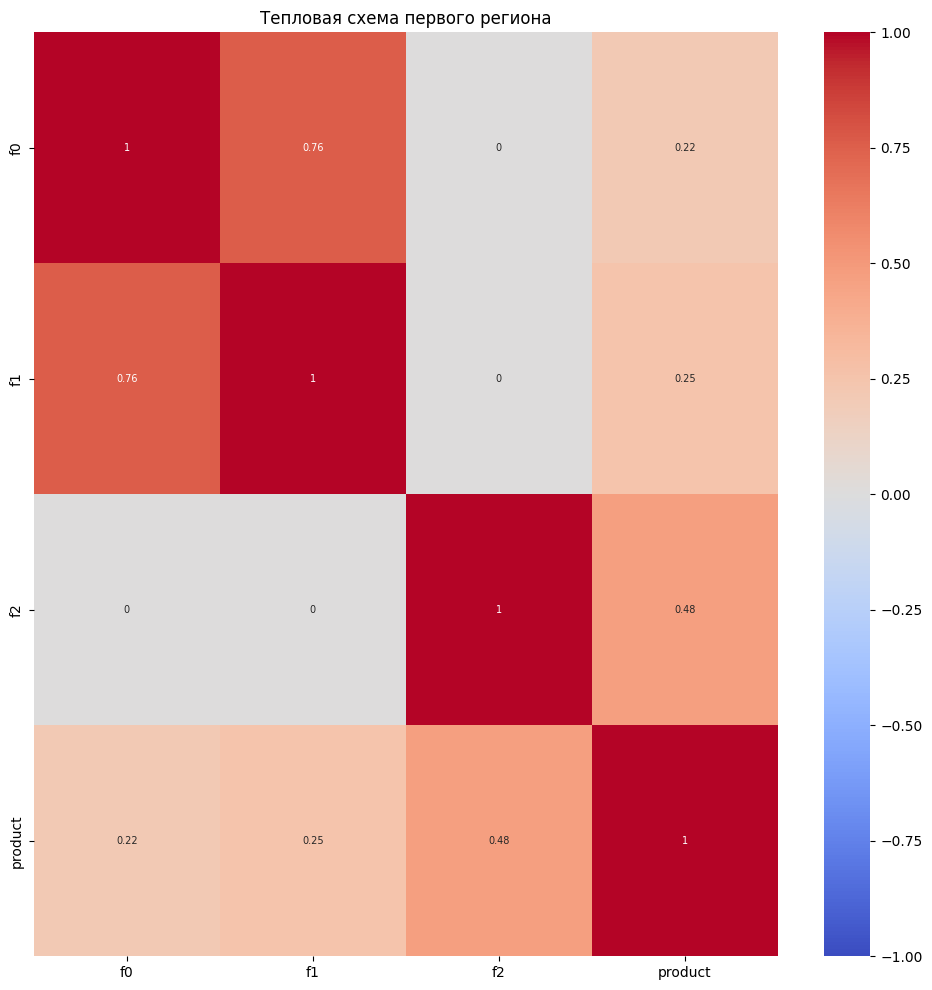

In [28]:
sns.heatmap(phik.phik_matrix(geo_data_0.drop('id', axis=1), interval_cols=num_col),annot=True, annot_kws={'size':7},\
            vmax=1, vmin=-1, cmap='coolwarm', center=0)
plt.title('Тепловая схема первого региона')
plt.show()

На тепловой карте для первого региона можем заметить сильную корелляцию между **f0,f1** и умеренную зависимость **f2 и product**

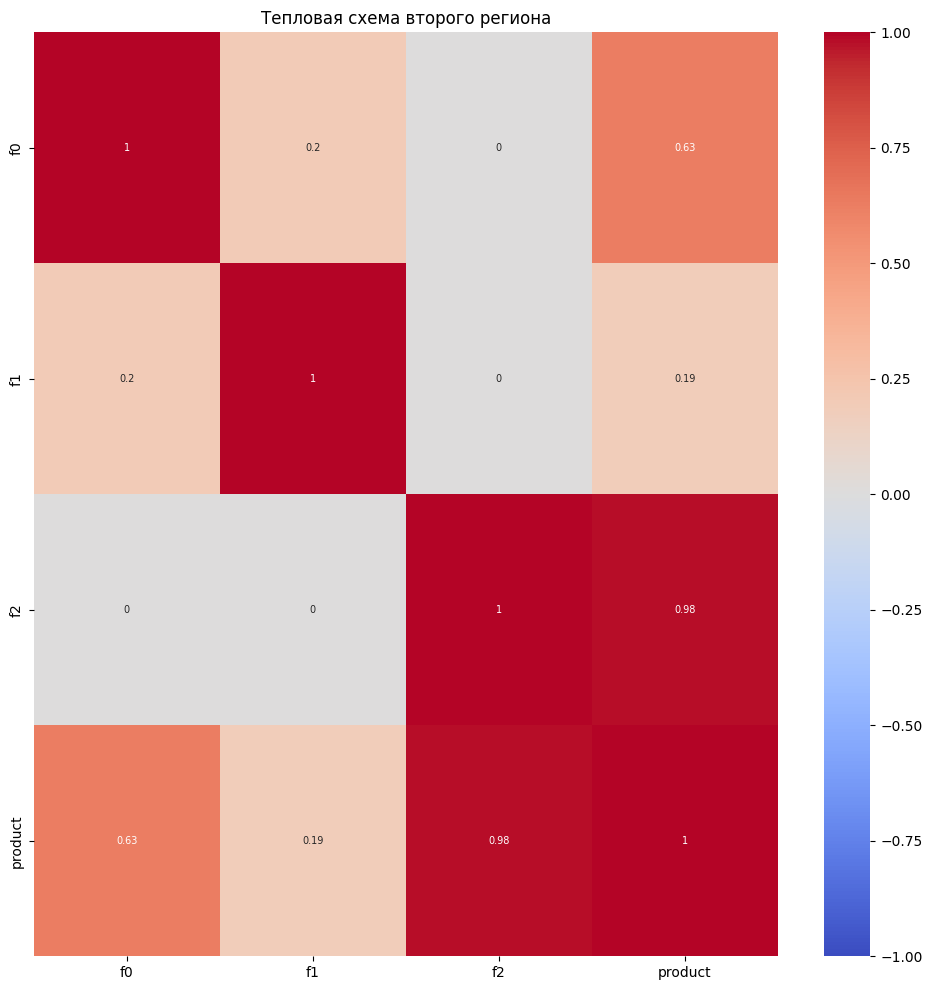

In [29]:
sns.heatmap(phik.phik_matrix(geo_data_1.drop('id', axis=1), interval_cols=num_col),annot=True, annot_kws={'size':7},\
            vmax=1, vmin=-1, cmap='coolwarm', center=0)

plt.title('Тепловая схема второго региона')
plt.show()

Как и предполагалось между **f2 и product** сильная связь, также стоит подметить заметную связь между **f0, product**

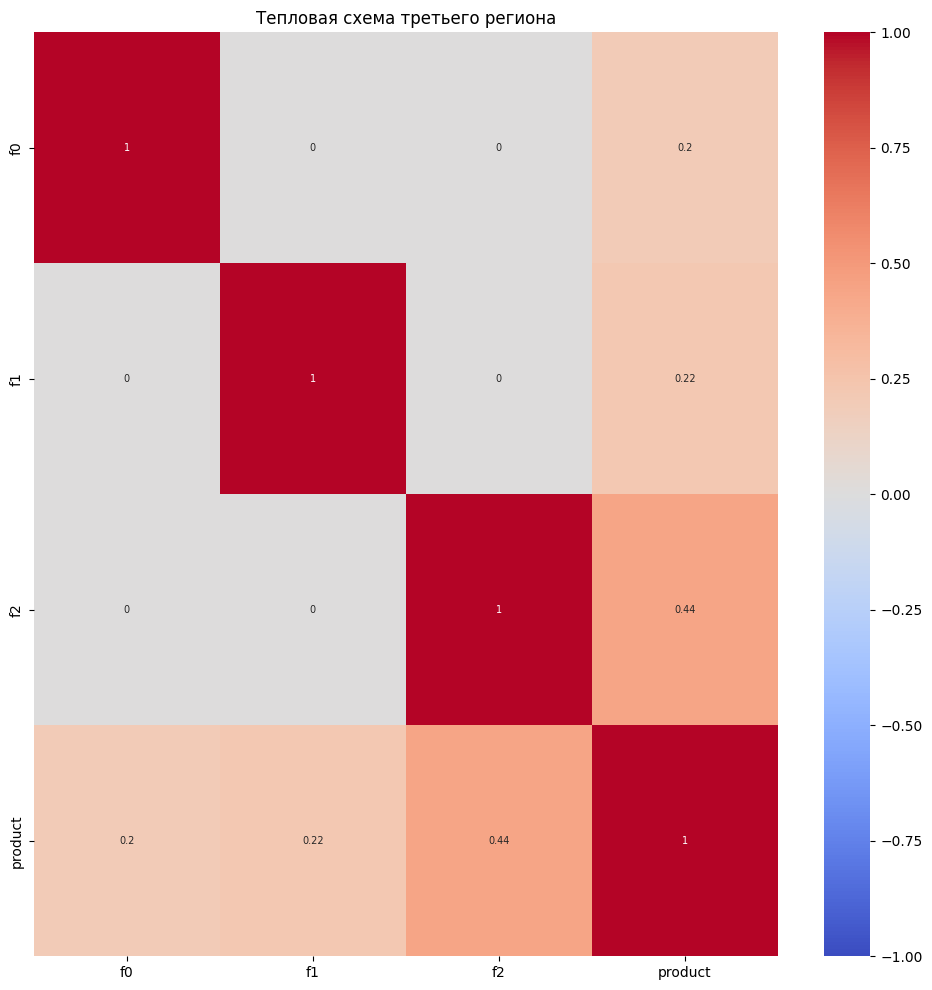

In [30]:
sns.heatmap(phik.phik_matrix(geo_data_2.drop('id', axis=1), interval_cols=num_col),annot=True, annot_kws={'size':7},\
            vmax=1, vmin=-1, cmap='coolwarm', center=0)

plt.title('Тепловая схема третьего региона')
plt.show()

Присутствует умеренная связь между **f2, product**

<div style="border-radius: 15px; box-shadow: 2px 2px 4px; border: 1px solid; background:OldLace; padding: 20px">

## Вывод по корелляционному анализу

При изучении таблиц с помощью кореляционной матрицы можно заметить сильную зависимость между **f2, product** для второго региона и умеренную для первого и третьего региона. Также для второго региона присутствует умеренная зависимость между **f0,product**. С помощью vif мультиколлинеарности не было обнаружено 

<div style="border-radius: 15px; box-shadow: 2px 2px 4px; border: 1px solid; background:OldLace; padding: 20px">

## Обучение модели

In [31]:
def model(data):
    X = data.drop(['id','product'], axis=1)
    y = pd.DataFrame(data['product'])
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)
    num_col = X.columns
    dummy = DummyRegressor()
    dummy.fit(X_train, y_train)
    y_pred = dummy.predict(X_test)
    print(f'Dummy: {mean_squared_error(y_test, y_pred, squared=False)}')
    data_prepossesor = ColumnTransformer([    
               ('num', StandardScaler(), num_col)],
                remainder='passthrough'
                                    )
    pipe_final = Pipeline([
                ('preprossesor', data_prepossesor),
                ('models', ElasticNet(random_state=42))
                    ])
    param_distribution = {
        'models__alpha': FloatDistribution(0.01,1.0, 1),
        'models__l1_ratio': FloatDistribution(0.01, 1.0, 1)
    }    

    opt = OptunaSearchCV(pipe_final, param_distribution, cv=5, n_trials=100, random_state=42,scoring='neg_root_mean_squared_error', verbose=0)
    opt.fit(X_train,y_train)
    y_pred = pd.DataFrame(opt.predict(X_test), columns=['pred'])
    rmse = mean_squared_error(y_test,y_pred,squared=True)
    return opt,y_pred, rmse, y_test

<div style="border-radius: 15px; box-shadow: 2px 2px 4px; border: 1px solid; background:OldLace; padding: 20px">
    
### Модель для первого региона

In [32]:
first_region = model(geo_data_0)

[I 2024-05-17 16:01:28,720] A new study created in memory with name: no-name-453fcb7c-2745-4621-9222-77cc0023558f
[I 2024-05-17 16:01:28,835] Trial 0 finished with value: -37.684296417236325 and parameters: {'models__alpha': 0.08117122579380917, 'models__l1_ratio': 0.4626622490126815}. Best is trial 0 with value: -37.684296417236325.


Dummy: 44.25870895385742


[I 2024-05-17 16:01:28,947] Trial 1 finished with value: -37.67241744995117 and parameters: {'models__alpha': 0.013743668829195008, 'models__l1_ratio': 0.04354060928873476}. Best is trial 1 with value: -37.67241744995117.
[I 2024-05-17 16:01:29,056] Trial 2 finished with value: -37.71743621826172 and parameters: {'models__alpha': 0.09340591646798577, 'models__l1_ratio': 0.03949328531300317}. Best is trial 1 with value: -37.67241744995117.
[I 2024-05-17 16:01:29,167] Trial 3 finished with value: -37.675635528564456 and parameters: {'models__alpha': 0.026598218416028396, 'models__l1_ratio': 0.021552302595488446}. Best is trial 1 with value: -37.67241744995117.
[I 2024-05-17 16:01:29,268] Trial 4 finished with value: -37.67429428100586 and parameters: {'models__alpha': 0.022513479085543797, 'models__l1_ratio': 0.043360121097566026}. Best is trial 1 with value: -37.67241744995117.
[I 2024-05-17 16:01:29,376] Trial 5 finished with value: -37.671366119384764 and parameters: {'models__alpha':

In [33]:
first_region[0].trials_dataframe().sort_values(by='value', ascending=False)[['number','value','params_models__alpha',\
                                                                          'params_models__l1_ratio']].head()

,number,value,params_models__alpha,params_models__l1_ratio
73,73,-37.671287,0.011442,0.994648
41,41,-37.671288,0.013043,0.997552
40,40,-37.671288,0.013948,0.991793
94,94,-37.671288,0.014350,0.998926
49,49,-37.671288,0.012227,0.988677


Лучшая модель оказалась с параметрами $l_1 = 0.995$, $alpha = 0.011$ c $RMSE = 37.67$

<div style="border-radius: 15px; box-shadow: 2px 2px 4px; border: 1px solid; background:OldLace; padding: 20px">

### Модель для второго региона

In [34]:
second_region = model(geo_data_1)

[I 2024-05-17 16:01:41,274] A new study created in memory with name: no-name-9b6cbb2d-0d76-44a1-8805-641280a98f67
[I 2024-05-17 16:01:41,408] Trial 0 finished with value: -2.1494531715940957 and parameters: {'models__alpha': 0.08117122579380917, 'models__l1_ratio': 0.4626622490126815}. Best is trial 0 with value: -2.1494531715940957.


Dummy: 45.971453392212496


[I 2024-05-17 16:01:41,542] Trial 1 finished with value: -1.0710587105629177 and parameters: {'models__alpha': 0.013743668829195008, 'models__l1_ratio': 0.04354060928873476}. Best is trial 1 with value: -1.0710587105629177.
[I 2024-05-17 16:01:41,676] Trial 2 finished with value: -3.8876643504992443 and parameters: {'models__alpha': 0.09340591646798577, 'models__l1_ratio': 0.03949328531300317}. Best is trial 1 with value: -1.0710587105629177.
[I 2024-05-17 16:01:41,822] Trial 3 finished with value: -1.4661686938880945 and parameters: {'models__alpha': 0.026598218416028396, 'models__l1_ratio': 0.021552302595488446}. Best is trial 1 with value: -1.0710587105629177.
[I 2024-05-17 16:01:41,954] Trial 4 finished with value: -1.3155882028438413 and parameters: {'models__alpha': 0.022513479085543797, 'models__l1_ratio': 0.043360121097566026}. Best is trial 1 with value: -1.0710587105629177.
[I 2024-05-17 16:01:42,095] Trial 5 finished with value: -0.8938303302435294 and parameters: {'models__

In [35]:
second_region[0].trials_dataframe().sort_values(by='value', ascending=False)[['number','value','params_models__alpha',\
                                                                          'params_models__l1_ratio']].head()

,number,value,params_models__alpha,params_models__l1_ratio
91,91,-0.889977,0.013653,0.993387
90,90,-0.890003,0.015723,0.999632
72,72,-0.890026,0.014834,0.994397
65,65,-0.890286,0.020636,0.999139
99,99,-0.890520,0.021401,0.992349


Лучшая модель оказалась с параметрами $l_1 = 0.993$, $alpha = 0.013$ с $RMSE = 0.89$

<div style="border-radius: 15px; box-shadow: 2px 2px 4px; border: 1px solid; background:OldLace; padding: 20px">

### Модель для третьего региона

In [36]:
third_region = model(geo_data_2)

[I 2024-05-17 16:01:55,298] A new study created in memory with name: no-name-52c02e8b-ba72-4ed4-a48e-fc4123b08388
[I 2024-05-17 16:01:55,419] Trial 0 finished with value: -40.03909336823854 and parameters: {'models__alpha': 0.08117122579380917, 'models__l1_ratio': 0.4626622490126815}. Best is trial 0 with value: -40.03909336823854.


Dummy: 44.72544859422637


[I 2024-05-17 16:01:55,541] Trial 1 finished with value: -40.03087813193956 and parameters: {'models__alpha': 0.013743668829195008, 'models__l1_ratio': 0.04354060928873476}. Best is trial 1 with value: -40.03087813193956.
[I 2024-05-17 16:01:55,677] Trial 2 finished with value: -40.06393399618186 and parameters: {'models__alpha': 0.09340591646798577, 'models__l1_ratio': 0.03949328531300317}. Best is trial 1 with value: -40.03087813193956.
[I 2024-05-17 16:01:55,799] Trial 3 finished with value: -40.03323904431171 and parameters: {'models__alpha': 0.026598218416028396, 'models__l1_ratio': 0.021552302595488446}. Best is trial 1 with value: -40.03087813193956.
[I 2024-05-17 16:01:55,917] Trial 4 finished with value: -40.03224772416878 and parameters: {'models__alpha': 0.022513479085543797, 'models__l1_ratio': 0.043360121097566026}. Best is trial 1 with value: -40.03087813193956.
[I 2024-05-17 16:01:56,026] Trial 5 finished with value: -40.029557217202026 and parameters: {'models__alpha': 

In [37]:
third_region[0].trials_dataframe().sort_values(by='value', ascending=False)[['number','value','params_models__alpha',\
                                                                          'params_models__l1_ratio']].head()

,number,value,params_models__alpha,params_models__l1_ratio
65,65,-40.029169,0.152126,0.999106
32,32,-40.029175,0.168037,0.998890
41,41,-40.029210,0.131141,0.997481
35,35,-40.029442,0.081701,0.976010
39,39,-40.029457,0.079822,0.973801


Лучшая модель оказалась с параметрами $l_1 = 0.999$, $alpha = 0.15$ с $RMSE = 40$

In [38]:
df = pd.DataFrame( [['Регион_1',first_region[1].mean()[0], first_region[1].std()[0],first_region[2]],
                    ['Регион_2',second_region[1].mean()[0], second_region[1].std()[0],second_region[2]],
                    ['Регион_3',third_region[1].mean()[0], third_region[1].std()[0],third_region[2]]],
                 columns= ['Регион','Средний запас сырья, тыс.бар', 'Среднеквадратичное отклонение, тыс.бар.','RMSE'])

In [39]:
df

,Регион,"Средний запас сырья, тыс.бар","Среднеквадратичное отклонение, тыс.бар.",RMSE
0,Регион_1,92.286636,23.104311,1425.900513
1,Регион_2,69.168742,45.945582,0.797318
2,Регион_3,94.822301,19.795236,1610.470471


<div style="border-radius: 15px; box-shadow: 2px 2px 4px; border: 1px solid; background:OldLace; padding: 20px">

## Вывод по обучению моделей

Для трех регионов были обучены три линейные модели. Для первого региона лучшая модель с гиперапаметрами  $l1 = 0.997$, $alpha = 0.013$ c $RMSE = 37.67$ Для второй региона -  $l1 = 0.993$, $alpha = 0.013$ с $RMSE = 0.89$ и для третьего региона - $l1 = 0.999$, $alpha = 0.075$ с $RMSE = 40$. Лучшую предсказательную способность имеет вторая модель это связано с тем, что у нас имеется сильная зависимость предиктора и целевого признака, что очень важно для линейных моделей. Средний запас сырья у первого и третьего региона примерно одинаковы и равны соответсвенно $92.4, 94.8$ тыс. баррелей, но у этих моделей и больше среднеквадратичная ошибка, чем у второй. 

<div style="border-radius: 15px; box-shadow: 2px 2px 4px; border: 1px solid; background:OldLace; padding: 20px">

## Расчет прибыли

In [40]:
BUDGET = 10 * 10**9
ONE_BARREL = 450 
LOSS_FREE_VOLUME = BUDGET / ONE_BARREL / 1000
print(f'Безубыточный объем сырья равен {round(LOSS_FREE_VOLUME,2)} тысяч баррель')

Безубыточный объем сырья равен 22222.22 тысяч баррель


In [41]:
def gain(data):
    product = data.sort_values(by='pred', ascending=False)['product'].iloc[:200].sum()
    gain_product = 450000 * product - BUDGET
    return gain_product

In [42]:
print(f'Для безубыточного производства в среднем  нужно для первого региона {np.ceil(LOSS_FREE_VOLUME / first_region[1].mean()[0])} скважина')
print(f'Для безубыточного производства в среднем  нужно для второго региона {np.ceil(LOSS_FREE_VOLUME / second_region[1].mean()[0])} скважины')
print(f'Для безубыточного производства в среднем  нужно для третьего региона {np.ceil(LOSS_FREE_VOLUME / third_region[1].mean()[0])} скважин')

Для безубыточного производства в среднем  нужно для первого региона 241.0 скважина
Для безубыточного производства в среднем  нужно для второго региона 322.0 скважины
Для безубыточного производства в среднем  нужно для третьего региона 235.0 скважин


Проведем Bootstrap с 1000 итерациями для определения прибыли. Будем в каждой итерации отбирать из 500 скважин 200 лучших скважин, предсказанных моделью и суммировать действительные значения объемов.Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков.

In [43]:
# Создадим датафреймы с предсказаными и целевыми признаком для каждого региона

reg_0 = pd.concat([first_region[1], first_region[3].reset_index(drop=True)], axis=1)
reg_1 = pd.concat([second_region[1], second_region[3].reset_index(drop=True)], axis=1)
reg_2 = pd.concat([third_region[1], third_region[3].reset_index(drop=True)], axis=1)

In [44]:
state = np.random.RandomState(12345)

In [45]:
gain_region_0, gain_region_1, gain_region_2 = [], [], []

In [46]:
for i in range(1000):
    data_sample_0 = reg_0.sample(n = 500, replace=True, random_state=state)
    data_sample_1 = reg_1.sample(n = 500, replace=True, random_state=state)
    data_sample_2 = reg_2.sample(n = 500, replace=True, random_state=state)
    gain_region_0.append(gain(data_sample_0))
    gain_region_1.append(gain(data_sample_1))
    gain_region_2.append(gain(data_sample_2))

In [47]:
gain_region_0 = pd.Series(gain_region_0)
gain_region_1 = pd.Series(gain_region_1)
gain_region_2 = pd.Series(gain_region_2)

In [48]:
#Рассчитаем квантили для регионов
lower_0 = np.quantile(gain_region_0, 0.025)
upper_0 = np.quantile(gain_region_0, 0.975)

lower_1 = np.quantile(gain_region_1, 0.025)
upper_1 = np.quantile(gain_region_1, 0.975)

lower_2 = np.quantile(gain_region_2, 0.025)
upper_2 = np.quantile(gain_region_2, 0.975)

print(f'95% Доверительный интервал прибыли для первого региона : {list(map(round,[lower_0, upper_0]))}')
print(f'95% Доверительный интервал прибыли для второго региона : {list(map(round,[lower_1, upper_1]))}')
print(f'95% Доверительный интервал прибыли для третьего региона : {list(map(round,[lower_2, upper_2]))}')

95% Доверительный интервал прибыли для первого региона : [-137035352, 901003643]
95% Доверительный интервал прибыли для второго региона : [81002193, 887911298]
95% Доверительный интервал прибыли для третьего региона : [-168905595, 879264517]


Рассчитает риск убытков

In [49]:
print(f'Риск убытков для первого региона составляет: {sum(gain_region_0 < 0) / gain_region_0.shape[0] * 100}%')
print(f'Риск убытков для второго региона составляет: {sum(gain_region_1 < 0) / gain_region_1.shape[0] * 100}%')
print(f'Риск убытков для третьего региона составляет: {sum(gain_region_2 < 0) / gain_region_2.shape[0] * 100}%')

Риск убытков для первого региона составляет: 7.7%
Риск убытков для второго региона составляет: 1.7999999999999998%
Риск убытков для третьего региона составляет: 8.0%


Оставим только второй регион, так как риск убытков для этого региона меньше 2.5%

Рассчитаем среднюю прибыль второго региона

In [50]:
print(f'Средняя прибыль для второго регоина составляет: {round(gain_region_1.mean())} рублей')

Средняя прибыль для второго регоина составляет: 485253214 рублей


<div style="border-radius: 15px; box-shadow: 2px 2px 4px; border: 1px solid; background:OldLace; padding: 20px">

## Вывод по расчету прибыли


С помощью техники Bootstrap для каждого региона были найдены 95% доверительный интервал прибыли и рассчитан риск убытков. На основе этих данных мы оставили только второй регион, так как риск убытков меньше 2.5%, а именно $1.8$% . Также средняя прибыль для второго региона составила  **485253214** рублей. Это решение можно обосновать с точностью модели, так как среднеквадратичная ошибка составила $0.89$, что точно описывает действительные значения целевого признака, по которым происходил расчет прибыли

<div style="border-radius: 15px; box-shadow: 2px 2px 4px; border: 1px solid; background:OldLace; padding: 20px">

# Вывод

Задача состояла в выборе локации для добычи нефти.
Для решения данной задачи нужно было построить модель для предсказания объемов запасов и определить регион с максимальной суммарной прибылью


1. В ходе предобработки данных не были выявлены пропуски и дубликаты, однако были замечены повторения id,которые были впоследствии удалены. Также для второго региона можно заметить, что целевой признак имеет дискретный набор данных.
2. По распределению количественных переменных можно заметить, что **f0, f1, product**  имеет множество пиков, а вот **f2** имеет вид нормального распределения с длинным левым хвостом.Как уже было подмечено ранее, столбец **product** имеет ограниченное количество значений. Столбец **f0** имеет вид двумодального распределения, **f1** нормальное распределение. Столбец **f2** как и целевой признак имеет распределение имеет дискретный характер.Для таблицы **geo_data_2** предикторы имеют нормальное распределение, а целевая переменная имеет множество пиков.
3. При изучении таблиц с помощью кореляционной матрицы можно заметить сильную зависимость между **f2, product** для второго региона и умеренную для первого и третьего региона. Также для второго региона присутствует умеренная зависимость между **f0, product**. С помощью vif мультиколлинеарности не было обнаружено
4. Для трех регионов были обучены три линейные модели. Для первого региона лучшая модель с гиперапаметрами  $l_1 = 0.997$, $alpha = 0.013$ c $RMSE = 37.67$ Для второй региона -  $l_1 = 0.993$, $alpha = 0.013$ с $RMSE = 0.89$ и для третьего региона - $l_1 = 0.999$, $alpha = 0.075$ с $RMSE = 40$. Лучшую предсказательную способность имеет вторая модель это связано с тем, что у нас имеется сильная зависимость предиктора и целевого признака, что очень важно для линейных моделей. Средний запас сырья у первого и третьего региона примерно одинаковы и равны соответсвенно $92.4, 94.8$ тыс. баррелей, но у этих моделей и больше среднеквадратичная ошибка, чем у второй.
5. С помощью техники Bootstrap для каждого региона были найдены 95% доверительный интервал прибыли и рассчитан риск убытков. На основе этих данных мы оставили только второй регион, так как риск убытков меньше 2.5%, а именно $1.8$% . Также средняя прибыль для второго региона составила  **485253214** рублей. Это решение можно обсоновать с точностью модели, так как среднеквадратичная ошибка составила $0.89$, что точно описывает действительные значения целевого признака, по которым происходил расчет прибыли
